In [25]:
%matplotlib inline

This notebook is aimed at getting all the effector candidates from the Pst_104E_genome as defined as the following.

Gene expression cluster analysis done by Jana Sperschneider cluster 8

In [26]:
import os
from Bio import SeqIO
import pandas as pd
import re
from pybedtools import BedTool
import numpy as np
import matplotlib.pyplot as plt

In [27]:
#define your input folders
CLUSTER_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Pst_104E_genome/gene_expression/Pst104_p_SecretomeClustering'
EFFECTORP_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Pst_104E_genome/Secretomes/EffectorP'
GFF_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/032017_assembly'
PROTEIN_ANNO_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/pa_26062017'
OUT_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/lists'

In [28]:
genome = 'Pst_104E_v12_'
p_effector_list = []
h_effector_list = []

In [29]:
#define what you want to take from the cluster folder or else adapt here
clusters = [ 8]
clusters_files = [os.path.join(CLUSTER_FOLDER, x) for x in os.listdir(CLUSTER_FOLDER)\
                 if x.startswith('Cluster') and x.endswith('_DEs.fasta') and int(x[7]) in clusters ]


In [30]:
#get all the sequence names into a list from the fasta headers 
for file in clusters_files:
    fh = open(file, 'r')
    for seq in SeqIO.parse(fh, 'fasta'):
        if 'hcontig' in seq.id:
            h_effector_list.append(seq.id)
        if 'pcontig' in seq.id:
            p_effector_list.append(seq.id)
    fh.close()

Change filename below to alter what to look at

In [31]:
#this will be the newly created file in the list folder and p_effector_file will be the variable
# for tracking the gene list
to_look_at = 'cluster_8.list'
p_effector_file = os.path.join(OUT_FOLDER, genome + to_look_at)


In [32]:
#write out the sets of effector candidates
fh = open(p_effector_file, 'w')
for ec in set(p_effector_list):
    print(ec, file=fh)
fh.close()

In [33]:
#subset the gff files as well 
#right now get this in
p_gff_file = [os.path.join(GFF_FOLDER, x) for x in os.listdir(GFF_FOLDER)\
                 if x.startswith(genome+'p_ctg') and x.endswith('anno.gff3') ][0]
h_gff_file = [os.path.join(GFF_FOLDER, x) for x in os.listdir(GFF_FOLDER)\
                 if x.startswith(genome+'h_ctg') and x.endswith('anno.gff3') ][0]

In [34]:
#get repeat gff files from REPET (not sure this fully works right now)
p_repeat_gff_fn = [os.path.join(GFF_FOLDER, x) for x in os.listdir(GFF_FOLDER)\
                 if x.startswith(genome+'p_ctg') and x.endswith('REPET.gff') ][0]

In the command line in /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/TE_analysis the superfamily gff files were sorted as followed and copied over into the lists folder
sort Pst_104E_v12_h_ctg.REPET.superfamily.gff -k1,1n -k4,4n > Pst_104E_v12_h_ctg.REPET.sorted.superfamily.gff

In [35]:
#get repeat gff files with superfamilies in the 'attributes' column
p_repeat_superfamily_gff_fn = [os.path.join(OUT_FOLDER, x) for x in os.listdir(OUT_FOLDER)\
                 if x.startswith(genome+'p_ctg') and x.endswith('REPET.sorted.superfamily.gff') ][0]


In [36]:
#gff header 
gff_header = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']

In [37]:
#now subset the gff files for effectors only
p_gff_df = pd.read_csv(p_gff_file, header = None, sep='\t', names= gff_header)
#before that we need to convert the gene ids to protein ids in the attribute column
p_gff_df['ID'] = p_gff_df.attributes.str.extract(r'ID=([^;]*);', expand=False)
p_gff_df.sort_values(by=['seqid', 'start'], inplace = True)

In [38]:
os.path.join(OUT_FOLDER,p_repeat_gff_fn.split('/')[-1] )

'/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/lists/Pst_104E_v12_p_ctg.REPET.gff'

In [39]:
#now write out dataframes for p_gff

#bed 6 file
p_effector_bed_fn = p_effector_file.replace('.list', '.gene.bed') #generate filename
print(p_effector_bed_fn)
#save out subset p_gff_df using the p_effector_list as filter (defined above). Outformat is a bed file
p_gff_df[(p_gff_df.type == 'gene') & (p_gff_df.ID.str.replace('TU', 'model').isin(p_effector_list))].\
    loc[:,['seqid', 'start', 'end', 'ID', 'score', 'strand']].to_csv(p_effector_bed_fn, header=None, index=None, sep='\t')

#do the same and generate a gff file
p_effector_gff_fn = p_effector_file.replace('.list', '.gene.gff3')    
print(p_effector_gff_fn)
p_gff_df[(p_gff_df.type == 'gene') & (p_gff_df.ID.str.replace('TU', 'model').isin(p_effector_list))].\
    loc[:,gff_header].to_csv(p_effector_gff_fn, header=None, index=None, sep='\t')


#bed 6 file no effectors
p_noeffector_bed_fn = p_effector_file.replace(to_look_at, 'no_cluster_8.gene.bed')
print(p_noeffector_bed_fn)
p_gff_df[(p_gff_df.type == 'gene') & (~p_gff_df.ID.str.replace('TU', 'model').isin(p_effector_list))].\
    loc[:,['seqid', 'start', 'end', 'ID', 'score', 'strand']].to_csv(p_noeffector_bed_fn, header=None, index=None, sep='\t')

#no effector gff and list
p_noeffector_gff_fn = p_effector_file.replace(to_look_at, 'no_cluster_8.gene.gff3')   
print(p_noeffector_gff_fn)
p_gff_df[(p_gff_df.type == 'gene') & (~p_gff_df.ID.str.replace('TU', 'model').isin(p_effector_list))].\
    loc[:,gff_header].to_csv(p_noeffector_gff_fn, header=None, index=None, sep='\t')

file_name = p_effector_file.replace(to_look_at, 'no_cluster_8.list')
print(file_name)
p_gff_df[(p_gff_df.type == 'gene') & (~p_gff_df.ID.str.replace('TU', 'model').isin(p_effector_list))]['ID'].str.replace('TU', 'model')\
    .to_csv(file_name, header=None, index=None, sep='\t')

/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/lists/Pst_104E_v12_cluster_8.gene.bed
/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/lists/Pst_104E_v12_cluster_8.gene.gff3
/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/lists/Pst_104E_v12_no_cluster_8.gene.bed
/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/lists/Pst_104E_v12_no_cluster_8.gene.gff3
/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/lists/Pst_104E_v12_no_cluster_8.list


In [40]:
#get BUSCO file names to be used in the anaylsis these are also in the list folder (OUT_PATH)
p_busco_gff_fn = p_effector_file.replace(to_look_at, 'p_busco.gene.gff3')
p_busco_bed_fn = p_effector_file.replace(to_look_at, 'p_busco.gene.bed')


In [41]:
#get the gff for all genes
p_gene_gff_fn = p_effector_file.replace(to_look_at, 'p_all.gene.gff3')

#get bed 6 for all genes
p_gene_bed_fn = p_effector_file.replace(to_look_at, 'p_all.gene.bed')


In [42]:
#get the distances between genes and TEs

#read in files and generate bedtool objects. Issue might be that same variable are used for the bed files
#while those are sometimes gff and sometimes bed. Needs changing
p_effector_bed = BedTool(p_effector_gff_fn)
p_noeffector_bed = BedTool(p_noeffector_gff_fn)
p_busco_bed = BedTool(p_busco_gff_fn)
p_repeats_bed = BedTool(p_repeat_superfamily_gff_fn)

#get closest repeat and make a df out of it
p_closest_rep_to_eff = p_effector_bed.closest(p_repeats_bed, d=True)
p_closest_rep_to_eff_df = p_closest_rep_to_eff.to_dataframe()

#here subset the repeat superfamily GFF to filder out smaller repeats if wanted
tmp_REPET = pd.read_csv(p_repeat_superfamily_gff_fn, header=None, sep='\t', names=gff_header)
tmp_REPET['distance'] = tmp_REPET.end - tmp_REPET.start
tmp_fn = p_repeat_superfamily_gff_fn.replace('superfamily', 'tmpsuperfamily')
tmp_REPET[tmp_REPET.distance > 400].loc[:,gff_header].to_csv(tmp_fn, header=None, sep='\t', index=None)

#read this in as repeat_df
p_repeats_bed = BedTool(tmp_fn)

In [43]:
#bed closest header when using gff as input files
bed_repeat_closest_header = [x +'_gene' for x in gff_header] + [x +'_repeat' for x in gff_header] + ['distance']

In [44]:
import warnings
warnings.filterwarnings('ignore')

Effector distance to closest repeat
                 18
count    308.000000
mean    2117.555195
std     3066.023727
min        0.000000
25%        0.000000
50%      994.500000
75%     2586.250000
max    17811.000000


(0, 10000)

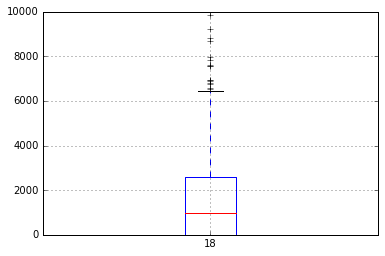

In [45]:
print('Effector distance to closest repeat')
print(p_effector_bed.closest(p_repeats_bed,d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_effector_bed.closest(p_repeats_bed, d=True, t='last').to_dataframe().boxplot(column=18)
plt.ylim(0, 10000)

BUSCO distance to closest repeat
                 18
count   1444.000000
mean    2938.963989
std     4085.483570
min        0.000000
25%      452.500000
50%     1321.000000
75%     3907.250000
max    41225.000000


(0, 10000)

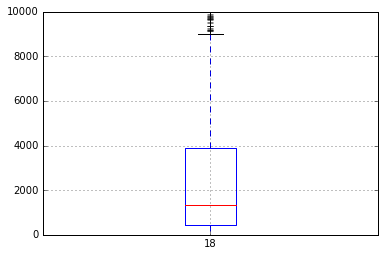

In [46]:
print('BUSCO distance to closest repeat')
print(p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().boxplot(column=18)
plt.ylim(0, 10000)

No Effector distance to closest repeat
                 18
count  15587.000000
mean    2295.757169
std     3778.415387
min        0.000000
25%        0.000000
50%      799.000000
75%     2991.000000
max    55526.000000


(0, 10000)

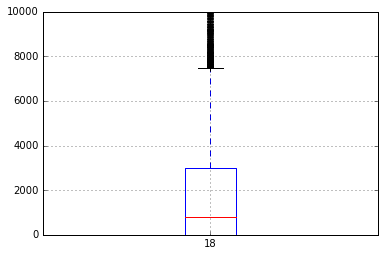

In [47]:
print('No Effector distance to closest repeat')
print(p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().boxplot(column=18)
plt.ylim(0, 10000)

In [ ]:
#some stuff in the following lines

In [48]:
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().groupby(17).count()[0].sort_values().tail(10)/len(p_noeffector_bed)*100

17
ClassII:MITE:?                3.617157
ClassI:LTR:?                  3.918054
ClassII:TIR:PIF-Harbinger     4.455826
ClassII:TIR:Tc1-Mariner       4.711908
ClassII:TIR:hAT               8.482714
ClassI:LARD:?                 8.950064
ClassI:LTR:Copia              9.302177
ClassII:TIR:?                 9.929577
ClassII:?:?                  12.976953
ClassI:LTR:Gypsy             17.791293
Name: 0, dtype: float64

In [49]:
p_effector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().groupby(17).count()[0].sort_values().tail(10)/len(p_effector_bed)*100

17
noCat                       3.246753
ClassII:TIR:Tc1-Mariner     3.571429
ClassI:LTR:?                5.844156
ClassII:TIR:hAT             6.168831
ClassII:MITE:?              7.792208
ClassI:LTR:Copia            8.116883
ClassII:TIR:?               9.090909
ClassI:LARD:?               9.740260
ClassI:LTR:Gypsy           14.285714
ClassII:?:?                18.831169
Name: 0, dtype: float64

In [50]:
p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().groupby(17).count()[0].sort_values().tail(10)/len(p_busco_bed)*100

17
ClassI:LTR:?                  4.362881
ClassII:TIR:PIF-Harbinger     4.432133
ClassII:TIR:Tc1-Mariner       5.401662
ClassII:MITE:?                5.747922
ClassI:LTR:Copia              7.963989
ClassII:TIR:hAT               8.518006
ClassI:LARD:?                10.526316
ClassII:TIR:?                12.119114
ClassI:LTR:Gypsy             13.573407
ClassII:?:?                  15.858726
Name: 0, dtype: float64

In [51]:
p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().groupby(17).mean()[18].sort_values().tail(10)

17
ClassII:TIR:hAT             3189.162393
ClassII:?:Sola              3290.000000
ClassI:LTR:Gypsy            3528.756906
ClassII:TIR:Tc1-Mariner     3675.421053
ClassII:Helitron:?          3765.230769
ClassI:LINE:Jockey          3832.500000
ClassII:TIR:MuDR            3947.156250
ClassII:Maverick:?          4384.285714
ClassI:LTR:ERV              7696.000000
ClassII:?:Academ           10287.000000
Name: 18, dtype: float64

In [52]:
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().groupby(17).mean()[18].sort_values().tail(10)

17
ClassII:TIR:CACTA           2458.177083
ClassII:TIR:MuDR            2654.820734
ClassII:TIR:hAT             2677.529274
noCat                       2677.621333
ClassII:TIR:?               2783.694550
ClassII:TIR:Tc1-Mariner     2883.061798
ClassII:Helitron:?          2974.724359
ClassI:LINE:Jockey          3003.733333
ClassII:MITE:?              3302.210526
ClassI:LTR:ERV             10918.400000
Name: 18, dtype: float64

In [53]:
p_effector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().groupby(17).mean()[18].sort_values().tail(10)

17
ClassI:LTR:Gypsy      2037.925000
noCat                 2140.538462
ClassI:DIRS:DIRS      2537.000000
ClassII:Helitron:?    2703.333333
ClassI:LTR:Copia      3298.652174
ClassII:TIR:?         3331.035714
ClassII:Maverick:?    3639.500000
ClassII:TIR:hAT       3736.062500
ClassII:TIR:CACTA     3959.000000
ClassI:?:?            4535.000000
Name: 18, dtype: float64

In [54]:
#now lookine at ClassII:?:? specifically
tmp_REPET[(tmp_REPET.distance > 400)&(tmp_REPET.attributes == 'ClassII:?:?')].loc[:,gff_header].to_csv(tmp_fn, header=None, sep='\t', index=None)

p_repeats_bed = BedTool(tmp_fn)

                  18
count     308.000000
mean    14867.250000
std     15499.382504
min        74.000000
25%      3726.750000
50%     10596.500000
75%     20149.500000
max    111250.000000


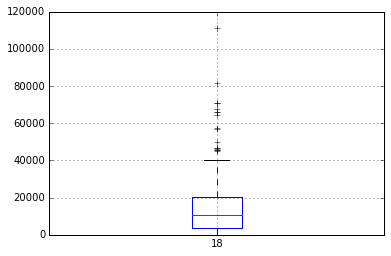

In [55]:
print(p_effector_bed.closest(p_repeats_bed,d=True,t='last', io=True).to_dataframe().iloc[:,18:20].describe())
p_effector_bed.closest(p_repeats_bed, d=True, t='last', io=True).to_dataframe().boxplot(column=18)

                  18
count    1296.000000
mean    17249.780093
std     19339.281875
min         2.000000
25%      4185.000000
50%     11023.000000
75%     23301.250000
max    156673.000000


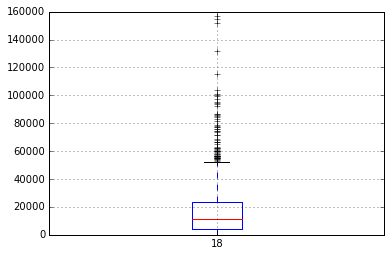

In [56]:
print(p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().iloc[:,18:20].describe())
p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().boxplot(column=18)

                  18
count    5798.000000
mean    15765.202484
std     17775.726928
min         2.000000
25%      4151.750000
50%     10118.500000
75%     21072.250000
max    187286.000000


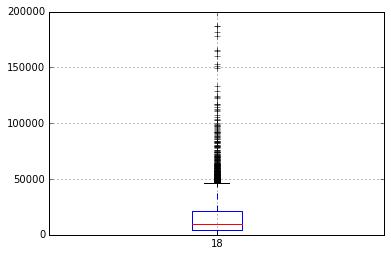

In [57]:
print(p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().iloc[:,18:20].describe())
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().boxplot(column=18)

                  18
count   15024.000000
mean    17478.975905
std     20851.892868
min         0.000000
25%      4034.000000
50%     10868.500000
75%     23203.250000
max    194780.000000


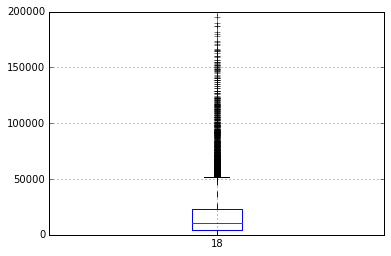

In [58]:
print(p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().boxplot(column=18)

In [59]:
#re-define the repeats here before looking into it with different perspective
tmp_REPET[tmp_REPET.distance > 400].loc[:,gff_header].to_csv(tmp_fn, header=None, sep='\t', index=None)
p_repeats_bed = BedTool(tmp_fn)

[]

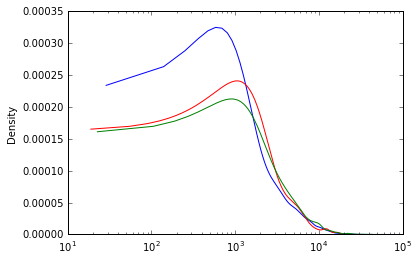

In [60]:
#densities without overlaps between repeats and genes
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().loc[:,18].plot(kind='density')
p_effector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().loc[:,18].plot(kind='density', color='r')
p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().loc[:,18].plot(kind='density', color='g')
plt.semilogx()

[]

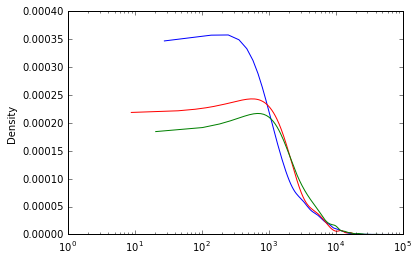

In [61]:
#densities with overlaps between repeats and genes
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().loc[:,18].plot(kind='density')
p_effector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().loc[:,18].plot(kind='density', color='r')
p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().loc[:,18].plot(kind='density', color='g')
plt.semilogx()

In [62]:
#define repeats
tmp_REPET = pd.read_csv(p_repeat_superfamily_gff_fn, header=None, sep='\t', names=gff_header)
tmp_REPET['distance'] = tmp_REPET.end - tmp_REPET.start
tmp_fn = p_repeat_superfamily_gff_fn.replace('superfamily', 'tmpsuperfamily')
tmp_REPET[tmp_REPET.distance > 400].loc[:,gff_header].to_csv(tmp_fn, header=None, sep='\t', index=None)

p_repeats_bed = BedTool(tmp_fn)

In [63]:
#summary of closest TEs not allowing for overlaps 
#####Needs fixing for genes that don't have a nearest neighbou######
p_br_closest_df = p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe(names = bed_repeat_closest_header)

p_br_closest_pt = p_br_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_br_closest_pt['superfamily_%'] = p_br_closest_pt.count_nonzero / p_br_closest_pt.count_nonzero.sum() *100
old_columns =[x for x in p_br_closest_pt.columns] 
new_columns = [x+'_busco' for x in p_br_closest_pt.columns]
p_br_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

p_er_closest_df = p_effector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe(names = bed_repeat_closest_header)

p_er_closest_pt = p_er_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_er_closest_pt['superfamily_%'] = p_er_closest_pt.count_nonzero / p_er_closest_pt.count_nonzero.sum() *100
old_columns =[x for x in p_er_closest_pt.columns] 
new_columns = [x+'_effector' for x in p_er_closest_pt.columns]
p_er_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

p_ner_closest_df = p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe(names = bed_repeat_closest_header)

p_ner_closest_pt = p_ner_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_ner_closest_pt['superfamily_%'] = p_ner_closest_pt['count_nonzero'] / p_ner_closest_pt['count_nonzero'].sum() *100
old_columns =[x for x in p_ner_closest_pt.columns] 
new_columns = [x+'_noeffector' for x in p_ner_closest_pt.columns]
p_ner_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

pd.options.display.float_format = '{:.2f}'.format

repeat_distance_df = pd.concat([p_ner_closest_pt.iloc[:,1:], p_br_closest_pt.iloc[:,1:], p_er_closest_pt.iloc[:,1:]], axis=1)

repeat_distance_df[repeat_distance_df['superfamily_%_effector'] >1].sort_values('superfamily_%_effector')

,,mean_noeffector,superfamily_%_noeffector,mean_busco,superfamily_%_busco,mean_effector,superfamily_%_effector
attributes_repeat,,,,,,,
ClassI:DIRS:DIRS,distance,1798.99,1.28,2274.42,1.32,2582.60,1.62
ClassII:TIR:CACTA,distance,3321.01,2.32,6555.92,0.90,3441.20,1.62
ClassII:Helitron:?,distance,3265.39,0.97,4449.82,0.76,2703.33,1.95
ClassII:TIR:MuDR,distance,2961.89,3.13,4569.71,1.94,1571.62,2.60
ClassII:TIR:PIF-Harbinger,distance,1978.80,4.48,2674.48,4.43,2221.44,2.92
noCat,distance,2816.53,2.65,2771.70,2.08,2782.70,3.25
ClassII:TIR:Tc1-Mariner,distance,3171.57,4.74,3836.76,5.40,3333.45,3.57
ClassI:LTR:?,distance,2550.36,3.94,2769.40,4.36,2024.61,5.84
ClassII:TIR:hAT,distance,2927.14,8.54,3211.91,8.52,3677.32,6.17


In [64]:
#summary of closest TEs allowing for overlaps
p_br_closest_df = p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe(names = bed_repeat_closest_header)

p_br_closest_pt = p_br_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_br_closest_pt['superfamily_%'] = p_br_closest_pt.count_nonzero / p_br_closest_pt.count_nonzero.sum() *100
old_columns =[x for x in p_br_closest_pt.columns] 
new_columns = [x+'_busco' for x in p_br_closest_pt.columns]
p_br_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

p_er_closest_df = p_effector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe(names = bed_repeat_closest_header)

p_er_closest_pt = p_er_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_er_closest_pt['superfamily_%'] = p_er_closest_pt.count_nonzero / p_er_closest_pt.count_nonzero.sum() *100
old_columns =[x for x in p_er_closest_pt.columns] 
new_columns = [x+'_effector' for x in p_er_closest_pt.columns]
p_er_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

p_ner_closest_df = p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe(names = bed_repeat_closest_header)

p_ner_closest_pt = p_ner_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_ner_closest_pt['superfamily_%'] = p_ner_closest_pt['count_nonzero'] / p_ner_closest_pt['count_nonzero'].sum() *100
old_columns =[x for x in p_ner_closest_pt.columns] 
new_columns = [x+'_noeffector' for x in p_ner_closest_pt.columns]
p_ner_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

pd.options.display.float_format = '{:.2f}'.format

repeat_distance_df = pd.concat([p_ner_closest_pt.iloc[:,1:], p_br_closest_pt.iloc[:,1:], p_er_closest_pt.iloc[:,1:]], axis=1)

repeat_distance_df[repeat_distance_df['superfamily_%_effector'] >1].sort_values('superfamily_%_effector')

,,mean_noeffector,superfamily_%_noeffector,mean_busco,superfamily_%_busco,mean_effector,superfamily_%_effector
attributes_repeat,,,,,,,
ClassI:DIRS:DIRS,distance,1478.37,1.07,2160.70,1.47,2537.00,1.33
ClassII:TIR:CACTA,distance,2458.18,1.82,2993.24,0.77,3959.00,1.78
ClassII:Helitron:?,distance,2974.72,1.18,3765.23,0.85,2703.33,2.67
ClassII:TIR:PIF-Harbinger,distance,1469.87,4.18,2284.90,4.26,1502.36,2.67
ClassII:TIR:MuDR,distance,2654.82,3.12,3947.16,2.09,1456.71,3.11
ClassII:TIR:Tc1-Mariner,distance,2883.06,4.94,3675.42,5.42,1535.27,3.11
noCat,distance,2677.62,2.79,2868.71,2.17,2140.54,4.44
ClassI:LARD:?,distance,2097.49,8.89,3156.92,9.83,1139.18,4.89
ClassI:LTR:?,distance,2235.78,3.89,2485.55,4.57,981.18,4.89


Add some sub_sets for randommization to get equal sized groups

In [66]:
#set the size of the subset here
sub_set = len(p_effector_bed)

In [67]:
p_effector_bed = BedTool(p_effector_bed_fn)
p_allgene_bed = BedTool(p_gene_bed_fn)
p_busco_bed = BedTool(p_busco_bed_fn)
p_allall_rand_sub = p_allgene_bed.random_subset(sub_set)
p_effector_bed_rand_sub = p_effector_bed.random_subset(sub_set)
p_busco_bed_rand_sub = p_busco_bed.random_subset(sub_set)

count      290.00
mean     97968.61
std     135303.65
min       1314.00
25%      12738.00
50%      41225.00
75%     146234.75
max     964418.00
Name: 12, dtype: float64


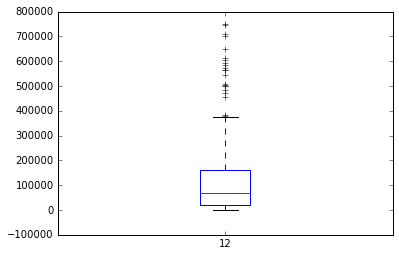

In [76]:
#get the distances with nearest gene effectors vs effectors
p_eself = p_effector_bed_rand_sub.closest(p_effector_bed_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12]
p_eself = p_eself[p_eself > -1]
p_eall = p_effector_bed_rand_sub.closest(p_allall_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12]
p_eall= p_eall[p_eall > -1]
print(p_eself.describe())
p_effector_bed_rand_sub.closest(p_allall_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12].plot(kind='box')

In [72]:
#some temp analysis
tmp_df = p_effector_bed_rand_sub.closest(p_effector_bed_rand_sub, d=True,  N=True).to_dataframe()

In [77]:
tmp_df[(tmp_df[12] < 36684) & (tmp_df[12] > -1)]

,0,1,2,3,4,5,6,7,8,9,10,11,12
10,pcontig_001,498220,500173,evm.TU.pcontig_001.124,.,-,pcontig_001,512910,515514,evm.TU.pcontig_001.127,.,-,12738
11,pcontig_001,512910,515514,evm.TU.pcontig_001.127,.,-,pcontig_001,498220,500173,evm.TU.pcontig_001.124,.,-,12738
13,pcontig_001,803807,804812,evm.TU.pcontig_001.197,.,+,pcontig_001,816431,817520,evm.TU.pcontig_001.200,.,-,11620
14,pcontig_001,816431,817520,evm.TU.pcontig_001.200,.,-,pcontig_001,803807,804812,evm.TU.pcontig_001.197,.,+,11620
16,pcontig_001,1663502,1665663,evm.TU.pcontig_001.395,.,-,pcontig_001,1667080,1668750,evm.TU.pcontig_001.396,.,-,1418
17,pcontig_001,1667080,1668750,evm.TU.pcontig_001.396,.,-,pcontig_001,1663502,1665663,evm.TU.pcontig_001.395,.,-,1418
21,pcontig_002,96349,98306,evm.TU.pcontig_002.21,.,+,pcontig_002,134744,136657,evm.TU.pcontig_002.29,.,-,36439
22,pcontig_002,134744,136657,evm.TU.pcontig_002.29,.,-,pcontig_002,96349,98306,evm.TU.pcontig_002.21,.,+,36439
26,pcontig_002,1626991,1628251,evm.TU.pcontig_002.396,.,-,pcontig_002,1652140,1652582,evm.TU.pcontig_002.403,.,-,23890
27,pcontig_002,1652140,1652582,evm.TU.pcontig_002.403,.,-,pcontig_002,1626991,1628251,evm.TU.pcontig_002.396,.,-,23890


count      288.00
mean    134159.38
std     141578.08
min        255.00
25%      25742.00
50%      93771.00
75%     189665.00
max     717378.00
Name: 12, dtype: float64


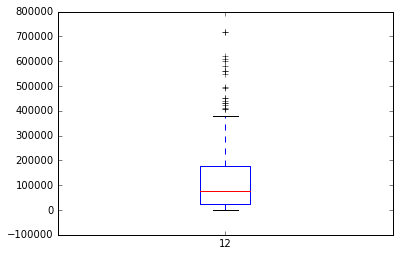

In [78]:
#get the distances with nearest gene all vs all subsampled
p_allall = p_allall_rand_sub.closest(p_allall_rand_sub, d=True, N=True).to_dataframe().iloc[:,12]
p_allall = p_allall[p_allall > -1]
print(p_allall.describe())
p_allall_rand_sub.closest(p_allall_rand_sub, d=True, N=True).to_dataframe().iloc[:,12].plot(kind='box')

In [80]:
#now with buscos
p_bself = p_busco_bed_rand_sub.closest(p_busco_bed_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12]
p_bself = p_bself[p_bself > -1]
print(p_bself.describe())

count       283.00
mean     119937.36
std      154338.64
min         300.00
25%       22955.00
50%       59475.00
75%      165502.50
max     1011378.00
Name: 12, dtype: float64


In [ ]:
p_noeffector_bed= BedTool(p_noeffector_bed_fn)
p_noeffector_rand_sub = p_noeffector_bed.random_subset(sub_set)
p_neself = p_noeffector_rand_sub.closest(p_noeffector_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12]
p_neself.describe()

In [ ]:
import seaborn as sns

In [ ]:
sns.distplot(p_bself[p_bself < 20000], bins=20, rug = True, label='BUSCO')
sns.distplot(p_eself[p_eself < 20000], bins=20, rug = True, color='g',label = 'effector')
sns.distplot(p_neself[p_neself <20000], bins=20, rug=True, color='red', label ='all_genes')
plt.legend()

In [ ]:
sns.distplot(p_bself[p_bself < 200000], bins=20,  label='BUSCO')
sns.distplot(p_eself[p_eself < 200000], bins=20,  color='g',label = 'effector')
sns.distplot(p_neself[p_neself <200000], bins=20,  color='red', label ='not_effectors', axlabel='Distance to closest neighbour [bp]')
plt.legend()

In [ ]:
sns.distplot(p_bself, bins=20,  label='BUSCO')
sns.distplot(p_eself, bins=20,  color='g',label = 'effector')
sns.distplot(p_neself, bins=20,  color='red', label ='not_effectors', axlabel='Distance to closest neighbour [bp]')
plt.legend()

In [ ]:
p_bself[p_bself < 20000].plot(kind='density')
p_eself[p_eself < 20000].plot(kind='density', color='g')
p_neself[p_neself < 20000].plot(kind='density', color='r')
p_eall[p_eall < 20000].plot(kind='density', color='y')
#plt.semilogx()
print(len(p_bself[p_bself < 20000]), len(p_eself[p_eself < 20000]), len(p_neself[p_neself < 20000]), len(p_eall[p_eall < 20000]))
plt.xlim(0, 20000)

In [ ]:
p_eall[p_eall < 20000].plot(kind='hist', bins=20, normed=True)
plt.ylim(0, 0.00050)

In [ ]:
p_eself[p_eself < 20000].plot(kind='hist', bins=20, normed=True)
plt.ylim(0, 0.00050)

In [ ]:
p_bself[p_bself < 20000].plot(kind='hist', bins=20,normed=True)
plt.ylim(0, 0.00050)

In [ ]:
p_neself[p_neself < 20000].plot(kind='hist',bins=20,normed=True)
plt.ylim(0, 0.00050)

It seems like there seems to be no clear link between cluster 8 gens and closest neighbour in terms of TEs in general. They all have the same distance in general.
Maybe Gypsy and ClassII:?:? should be looked at more carefully. Those are depleted and enriched in busco and effector genes. In general there seems to be a trend towards ClassII elements compared to ClassI in effector candidates.


It seems that effectors are closer together than noneffector genes. Buscos also seem to cluster a bit. Let's see if we can visualize the location of genes on certain contigs vs repeats and such.

In [ ]:
#start with getting effectors per contig divided by length divded by # of overall genes

In [ ]:
effector_bdf = pd.read_csv(p_effector_bed_fn, header=None, sep='\t')

In [ ]:
p_effectors_per_contig  = effector_bdf.groupby(0).count()[1]
p_effectors_per_contig.name = 'effectors'

In [ ]:
p_all_genes_per_contig = pd.read_csv(p_gene_bed_fn, header=None, sep='\t').groupby(0).count()[1]
p_all_genes_per_contig.name = 'all_genes'
p_noeffectors_per_contig = pd.read_csv(p_noeffector_bed_fn, header=None, sep='\t').groupby(0).count()[1]
p_noeffectors_per_contig.name = 'no_effectors'
p_busco_per_contig = pd.read_csv(p_busco_bed_fn, header=None, sep='\t').groupby(0).count()[1]
p_busco_per_contig.name = 'buscos'

In [ ]:
p_contig_length = pd.read_csv(os.path.join(GFF_FOLDER, 'Pst_104E_v12_p_ctg.genome_file'), header = None,\
                          names=['contig' , 'length'], sep='\t').sort_values('contig')

In [ ]:
p_contig_length.index = p_contig_length.contig

In [ ]:
p_contig_length = p_contig_length.loc[:, 'length']

In [ ]:
gene_dis_per_contig = pd.concat([p_contig_length,p_all_genes_per_contig,p_noeffectors_per_contig,p_busco_per_contig,  p_effectors_per_contig, ], axis = 1)

In [ ]:
from scipy.stats import chisquare

In [ ]:
gene_dis_per_contig.fillna(value=0, inplace=True)

In [ ]:
gene_dis_per_contig.effectors.sum()

In [ ]:
#chisquare for genes per contig vs bases per contig
chisquare(gene_dis_per_contig.length.values/gene_dis_per_contig.length.sum()\
          , gene_dis_per_contig.all_genes.values/gene_dis_per_contig.all_genes.sum())

In [ ]:
chisquare(gene_dis_per_contig.buscos.values/gene_dis_per_contig.buscos.sum()\
          , gene_dis_per_contig.all_genes.values/gene_dis_per_contig.all_genes.sum())

In [ ]:
gene_dis_per_contig['%busco'] = gene_dis_per_contig.buscos.values/gene_dis_per_contig.buscos.sum() *100
gene_dis_per_contig['%effector'] = gene_dis_per_contig.effectors.values/gene_dis_per_contig.effectors.sum() *100
gene_dis_per_contig['%all_genes'] = gene_dis_per_contig.all_genes.values/gene_dis_per_contig.all_genes.sum() *100
gene_dis_per_contig['%no_effector'] = gene_dis_per_contig.no_effectors.values/gene_dis_per_contig.no_effectors.sum() *100

In [ ]:
chisquare(gene_dis_per_contig['%effector'], f_exp = gene_dis_per_contig['%all_genes'])

In [ ]:
gene_dis_per_contig.loc[:,['%effector', '%all_genes','%no_effector' ,'%busco']]

In [ ]:
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes']) &\
                    (gene_dis_per_contig['%effector'] > gene_dis_per_contig['%busco'])].loc[:,['effectors', '%effector', '%all_genes']].index

In [ ]:
#effectors per contig > than expected
gene_dis_per_contig[((gene_dis_per_contig['%effector'] / gene_dis_per_contig['%all_genes']) > 1.5) & (gene_dis_per_contig['%effector'] > 0.9)]\
.loc[:,['effectors', '%effector', 'all_genes','%all_genes']].sort_values('effectors', ascending=False)

In [ ]:
#sum off all effectors on enriched? contigs
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes'])].sum()

In [ ]:
#sum off all effectors on enriched? contigs
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes'])].loc[:,['effectors', '%effector', '%all_genes']]['effectors'].sum()

In [ ]:
#sum off all effectors on enriched? contigs
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes'])]\
    .loc[:,['effectors', '%effector', '%all_genes']].sort_values('effectors', ascending = False)

In [ ]:
gene_dis_per_contig['effectors'].sum()

In [ ]:
gene_dis_per_contig[(gene_dis_per_contig['%busco'] / gene_dis_per_contig['%all_genes'] > 1.2) & (gene_dis_per_contig['%busco'] > 0.5 )\
                    ].loc[:,['buscos', '%busco', '%all_genes']]

In [ ]:
gene_dis_per_contig[(gene_dis_per_contig['%busco'] / gene_dis_per_contig['%all_genes'] > 1.2) \
                    ].loc[:,['buscos', '%busco', '%all_genes']]['buscos'].sum()

In [ ]:
gene_dis_per_contig[(gene_dis_per_contig['%busco'] / gene_dis_per_contig['%effector'] < 1) & \
                    (gene_dis_per_contig['%all_genes'] / gene_dis_per_contig['%effector'] < 1) ].sum()

In [ ]:
gene_dis_per_contig[(gene_dis_per_contig['%busco'] / gene_dis_per_contig['%all_genes'] > 1.0000001) & \
                   (gene_dis_per_contig['%effector'] / gene_dis_per_contig['%all_genes'] < 0.9999) ].sum()

Check if genes or TEs are the next closest to effectors

In [ ]:
tmp_REPET = pd.read_csv(p_repeat_superfamily_gff_fn, header=None, sep='\t', names=gff_header).sort_values(['seqid','start'])
tmp_REPET['distance'] = tmp_REPET.end - tmp_REPET.start

tmp_fn = p_repeat_superfamily_gff_fn.replace('superfamily.gff', 'tmpsuperfamily.bed')
tmp_REPET[tmp_REPET.distance > 400].loc[:,['seqid', 'start', 'end', 'attributes', 'score', 'strand']].to_csv(tmp_fn, header=None, sep='\t', index=None)

p_repeats_bed = BedTool(tmp_fn)

In [ ]:
p_effector_bed.head()

In [ ]:
p_allgene_bed.head()

In [ ]:
p_noeffector_bed.head()

In [ ]:
len(p_effector_bed)

In [ ]:
tmp_df = p_effector_bed.closest( [p_repeats_bed.fn,p_allgene_bed.fn] , mdb='all', d=True, N=True).to_dataframe()

tmp_df.rename(columns={10: 'ID'}, inplace=True)

print('Per of effectors having genes as closest %f' % (tmp_df[tmp_df.ID.str.contains('evm')][0].count()/len(p_effector_bed)*100))

print('Per of effectors having TE as closest %f' % (tmp_df[~tmp_df.ID.str.contains('evm')][0].count()/len(p_effector_bed)*100))



Get 5 and 3 prime distances of genes

In [ ]:
g_to_g_3 = p_allgene_bed.closest( p_allgene_bed.fn ,  N=True, iu=True, D='a' ).to_dataframe().iloc[:,[3,12]]


g_to_g_3.rename(columns={12:'3_distance'}, inplace=True)

g_to_g_5 = p_allgene_bed.closest( p_allgene_bed.fn ,  N=True, id=True, D='a' ).to_dataframe().iloc[:,[3,12]]
g_to_g_5.rename(columns={12:'5_distance'}, inplace=True)

g_to_g_merged = g_to_g_3.merge(g_to_g_5)

#needs to be fixed to take boundaries into account

g_to_g_merged = g_to_g_merged[~((g_to_g_merged['5_distance'] == -1) & g_to_g_merged[3].str.endswith('.1')) ]

g_to_g_merged=  g_to_g_merged[g_to_g_merged['3_distance'] > 1]

g_to_g_merged['5_distance'] = abs(g_to_g_merged['5_distance'])
g_to_g_merged['5_distance_log10'] = np.log10(g_to_g_merged['5_distance'])
g_to_g_merged['3_distance_log10'] = np.log10(g_to_g_merged['3_distance'])

sns.jointplot(x='3_distance', y='5_distance', data=g_to_g_merged, kind="kde")



#now for effectors 
e_to_g_3 = p_effector_bed.closest( p_allgene_bed.fn ,  N=True, iu=True, D='a' ).to_dataframe().iloc[:,[3,12]]


e_to_g_3.rename(columns={12:'3_distance'}, inplace=True)

e_to_g_5 = p_effector_bed.closest( p_allgene_bed.fn ,  N=True, id=True, D='a' ).to_dataframe().iloc[:,[3,12]]
e_to_g_5.rename(columns={12:'5_distance'}, inplace=True)

e_to_g_merged = e_to_g_3.merge(g_to_g_5)

#needs to be fixed to take boundaries into account

e_to_g_merged = e_to_g_merged[~((e_to_g_merged['5_distance'] == -1) & e_to_g_merged[3].str.endswith('.1')) ]

e_to_g_merged=  e_to_g_merged[e_to_g_merged['3_distance'] > 1]

e_to_g_merged['5_distance'] = abs(e_to_g_merged['5_distance'])



sns.jointplot(x='3_distance', y='5_distance', data=e_to_g_merged, kind="kde")


#now for effectors 
b_to_g_3 = p_busco_bed.closest( p_allgene_bed.fn ,  N=True, iu=True, D='a' ).to_dataframe().iloc[:,[3,12]]


b_to_g_3.rename(columns={12:'3_distance'}, inplace=True)

b_to_g_5 = p_busco_bed.closest( p_allgene_bed.fn ,  N=True, id=True, D='a' ).to_dataframe().iloc[:,[3,12]]
b_to_g_5.rename(columns={12:'5_distance'}, inplace=True)

b_to_g_merged = b_to_g_3.merge(b_to_g_5)

#needs to be fixed to take boundaries into account

b_to_g_merged = b_to_g_merged[~((b_to_g_merged['5_distance'] == -1) & b_to_g_merged[3].str.endswith('.1')) ]

b_to_g_merged=  b_to_g_merged[b_to_g_merged['3_distance'] > 1]

b_to_g_merged['5_distance'] = abs(b_to_g_merged['5_distance'])



sns.jointplot(x='3_distance', y='5_distance', data=b_to_g_merged, kind="kde")


sns.jointplot(x='3_distance', y='5_distance', data=e_to_g_merged, kind="kde", color='r', xlim=10000, ylim=10000)
sns.jointplot(x='3_distance', y='5_distance', data=g_to_g_merged, kind="kde", xlim=10000, ylim=10000)


sns.jointplot(x='3_distance', y='5_distance', data=e_to_g_merged[(e_to_g_merged['5_distance'] < 10000) &\
        (e_to_g_merged['3_distance'] < 10000)], kind="hex", color='r',xlim=[0,10000], ylim=[0,10000],\
             marginal_kws=dict(bins=30))


sns.jointplot(x='3_distance', y='5_distance', data=b_to_g_merged[(b_to_g_merged['5_distance'] < 10000) &\
        (b_to_g_merged['3_distance'] < 10000)], kind="hex",color='g', xlim=[0,10000], ylim=[0,10000],\
              marginal_kws=dict(bins=30))

sns.jointplot(x='3_distance', y='5_distance', data=g_to_g_merged[(g_to_g_merged['5_distance'] < 10000) &\
        (g_to_g_merged['3_distance'] < 10000)], kind="hex", xlim=[0,10000], ylim=[0,10000],\
              marginal_kws=dict(bins=30))